## 문제
MNIST 데이터를 불러들여 훈련 세트, 검증 세트, 테스트 세트로 나눕니다.
그런 다음 랜덤 포레스트 분류기, 엑스트라 트리 분류기, SVM 분류기 같은 여러 종류의 분류기를 훈련시킵니다.
그리고 검증 세트에서 개개의 분류기보다 더 높은 성능을 내도록 이들을 간접 혹은 직접 투표 방법을 사용해 앙상블로 연결해보세요.
앙상블을 얻고 나면 테스트 세트로 확인해보세요. 개개의 분류기와 비교해서 성능이 어느 정도 향상되나요?

## 풀이
우선 MNIST 데이터셋을 로드합니다.

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)
mnist.target = mnist.target.astype(np.uint8)

In [2]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(mnist.data, mnist.target, test_size=10_000)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10_000)

그리고 랜덤 포레스트, 엑스트라 트리, SVM 등의 분류기를 훈련시킵니다.

In [3]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

random_forest_clf = RandomForestClassifier(n_estimators=100)
extra_tree_clf = ExtraTreesClassifier(n_estimators=100)
svm_clf = LinearSVC(max_iter=100, tol=20)
mlp_clf = MLPClassifier()

In [4]:
estimators = [random_forest_clf, extra_tree_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Train", estimator.__class__.__name__)
    estimator.fit(X_train, y_train)

Train RandomForestClassifier
Train ExtraTreesClassifier
Train LinearSVC
Train MLPClassifier


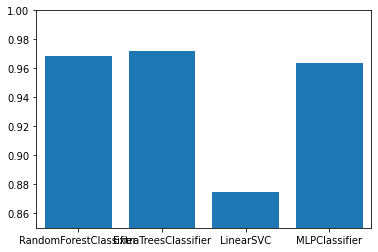

In [5]:
import matplotlib.pyplot as plt

plt.bar(range(len(estimators)), [estimator.score(X_val, y_val) for estimator in estimators])
plt.xticks(range(len(estimators)), [estimator.__class__.__name__ for estimator in estimators])
plt.axis([-0.5, len(estimators)-0.5, 0.85, 1.0])
plt.show()

위 그래프에서 왼쪽부터 랜덤 포레스트, 엑스트라 트리, SVM, MLP이다.
SVM의 성능이 낮다. 일단 놔두고 앙상블로 연결해 보자.


In [6]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier([
    ("random_forest_clf", random_forest_clf),
    ("extra_tree_clf", extra_tree_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf)
])

In [7]:
voting_clf.fit(X_train, y_train)
voting_clf.score(X_val, y_val)

0.9719

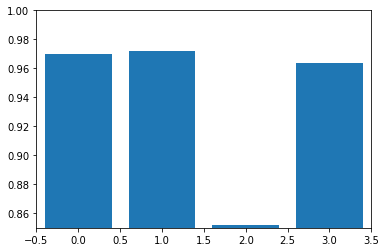

In [8]:
plt.bar(range(len(voting_clf.estimators_)), [estimator.score(X_val, y_val) for estimator in voting_clf.estimators_])
plt.axis([-0.5, len(voting_clf.estimators_)-0.5, 0.85, 1.0])
plt.show()

SVM을 지웠을 때 성능이 나아지는지 확인해 보자.

In [9]:
voting_clf.set_params(svm_clf=None)
voting_clf.score(X_val, y_val)

0.9719

성능에 변화가 생겼다. 이제 간접 투표기를 사용해 보자.

In [13]:
del voting_clf.estimators_[2] # LinearSVC를 남겨놓을 경우 오류가 발생함
voting_clf.voting = "soft"
voting_clf.score(X_val, y_val)

0.9688

간접 투표 방식보다 직접 투표가 나은 것을 확인할 수 있다.
이제 테스트 세트로 성능을 확인해 보자.

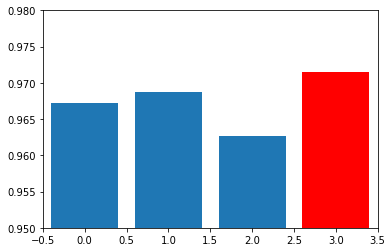

In [19]:
voting_clf.voting = "hard"
plt.bar(range(len(voting_clf.estimators_)), [estimator.score(X_test, y_test) for estimator in voting_clf.estimators_])
plt.bar(len(voting_clf.estimators_), voting_clf.score(X_test, y_test), color="red")
plt.axis([-0.5, len(voting_clf.estimators_)+1-0.5, 0.95, 0.98])
plt.show()
